In [4]:
import arrayworm as aw
import importlib as imp
imp.reload(aw)


<module 'arrayworm' from '/home/hornung/projects/pyworm/arrayworm.py'>

In [8]:
from numpy import linspace
import exactdiag as ed
[ed.t3_su3_sq(mu3=mu3, beta=0.5, J=1) for mu3 in linspace(0,4,100)]

[0.37887788278567885,
 0.37894439827254706,
 0.37914394778494914,
 0.37947654047128554,
 0.37994219155558295,
 0.3805409223025352,
 0.38127275996856863,
 0.38213773773893245,
 0.3831358946508294,
 0.38426727550258993,
 0.38553193074890224,
 0.3869299163821175,
 0.3884612937996369,
 0.3901261296574076,
 0.39192449570954263,
 0.3938564686340887,
 0.39592212984497044,
 0.3981215652901375,
 0.4004548652359485,
 0.40292212403782846,
 0.4055234398972355,
 0.4082589146049868,
 0.41112865327098497,
 0.41413276404040456,
 0.4172713577963888,
 0.4205445478493268,
 0.4239524496127755,
 0.42749518026610034,
 0.4311728584039214,
 0.4349856036724445,
 0.43893353639278,
 0.4430167771713489,
 0.4472354464974865,
 0.4515896643283652,
 0.4560795496613653,
 0.4607052200940288,
 0.46546679137175145,
 0.47036437692336464,
 0.4753980873847821,
 0.48056803011089455,
 0.48587430867590126,
 0.4913170223622913,
 0.4968962656386924,
 0.5026121276268223,
 0.5084646915577902,
 0.5144540342180182,
 0.52058022538505

In [74]:
imp.reload(aw)
testlat = aw.Lattice(beta=1,s1=2,s2=2, ics=["u","u"], mu3=1)
tw = aw.Worm(testlat)
print(tw.direction)
tw.nextevcs
tw.nextevnbs
tw.step()

BWD


In [78]:
import cProfile
def test_run():
    imp.reload(aw)
    testlat = aw.Lattice(beta=1,s1=2,s2=2, ics=["u","u"], mu3=1)

    for i in range(10000):
        tw = aw.Worm(testlat)
        tw.run()
        
cpr = cProfile.Profile()    
cpr.enable()
test_run()
cpr.disable()
cpr.print_stats(sort='time')


         4656428 function calls (4656421 primitive calls) in 6.112 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
   532395    0.597    0.000    0.597    0.000 arrayworm.py:99(find_event_in_dir)
   321708    0.577    0.000    0.577    0.000 arrayworm.py:235(newspin)
    83039    0.497    0.000    0.497    0.000 {method 'exponential' of 'mtrand.RandomState' objects}
    96479    0.346    0.000    5.541    0.000 arrayworm.py:397(step)
    96479    0.328    0.000    1.361    0.000 arrayworm.py:377(get_decay_constants)
    96479    0.311    0.000    1.324    0.000 arrayworm.py:386(sample_decay_time)
   106479    0.305    0.000    0.756    0.000 arrayworm.py:232(<listcomp>)
   106479    0.275    0.000    1.177    0.000 arrayworm.py:229(find_next_events)
   385916    0.239    0.000    0.617    0.000 arrayworm.py:362(get_state)
   553755    0.225    0.000    0.225    0.000 {built-in method builtins.sum}
    43635    0.216    0.00

In [86]:
imp.reload(aw)
start = timer()

testlat = aw.Lattice(beta=1,s1=2,s2=2, ics=["u","u"], mu3=1)
for i in range(10000):
        tw = aw.Worm(testlat)
        tw.run()
        
stop = timer()
print(stop-start)





4.651366721838713


In [117]:
import csv
def tsqfromfile(beta):
    data =[]
    with open('/scratch1/hornung/dtvspyworm/ct/su3/results/BETAS-{0:.2f}.dat'.format(beta)) as csvfile:
        readCSV = csv.reader(csvfile, delimiter='\t')
        for row in readCSV:
            data = row
    
    return float(data[4])


betacts = [b*0.05 for b in range(1,41)]
t3wqcts = [tsqfromfile(beta) for beta in betacts ]

In [29]:
imp.reload(aw)
from numpy import linspace
from joblib import Parallel, delayed
import multiprocessing
import exactdiag as ed
imp.reload(ed)
num_cores = multiprocessing.cpu_count()
from timeit import default_timer as timer

start = timer()

mu3s = linspace(0.,8,21)
betas = range(1,9)

pywormresults = {}

for beta in betas:
    t3pyworm = Parallel(n_jobs=num_cores)(delayed(aw.launch_simulation)(
                        beta=beta,mu3=mu3,termsteps=100000, wormruns=2000000, ics =["d","u"]) for mu3 in mu3s)
    pywormresults.update({beta:t3pyworm})
    
stop = timer()


print(stop-start)


56895.542214794084


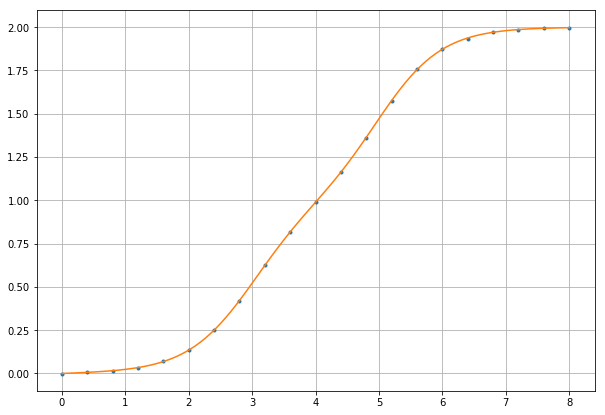

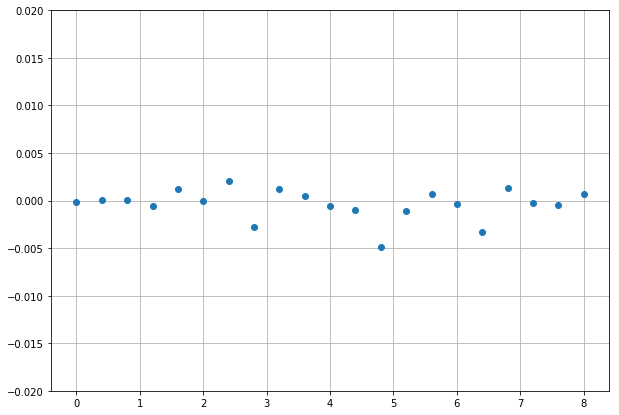

In [114]:
from matplotlib import pyplot as plt
ind = 2
mu3ed = linspace(0,8,100)
t3ed={beta:[ed.t3_su3(mu3=mu3, beta=beta, J=1) for mu3 in mu3ed] for beta in betas}
plt.figure(figsize=[10,7])
plt.grid(True)
plt.plot(mu3s,pywormresults[ind], '.')
plt.plot(mu3ed,t3ed[ind])
#plt.plot(mu3cts,t3cts)
plt.show()

residues = [ x-y for x,y in zip(pywormresults[ind], [ed.t3_su3(mu3=mu3, beta=ind,J=1) for mu3 in mu3s])]
plt.figure(figsize=[10,7])
plt.plot(mu3s,residues,'o' )
plt.ylim(-0.02,0.02)
plt.grid(True)
plt.show()

In [42]:
import csv
data = [pywormresults[beta] for beta in range(1,9)]
file = open('validation-values.dat', 'w')
with file:
    writer = csv.writer(file)
    writer.writerows(data)
     

In [108]:
import foo as f
imp.reload(f)
ts =f.Site()

In [109]:
for event in ts.eventlist:
    print(event["time"])

0
1
